### FLO - Gözetimsiz Öğrenme ile Müşteri Segmentasyonu

**İş Problemi**

FLO müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor. Buna yönelik olarak müşterilerin davranışları tanımlanacak ve bu davranışlardaki öbeklenmelere göre gruplar oluşturulacak.

**Veri Seti Hikayesi**

Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan) olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

**Değişkenler**

**master_id:** Eşsiz müşteri numarası

**order_channel:** Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile, Offline)

**last_order_channel:** En son alışverişin yapıldığı kanal

**first_order_date:** Müşterinin yaptığı ilk alışveriş tarihi

**last_order_date:** Müşterinin yaptığı son alışveriş tarihi

**last_order_date_online:** Müşterinin online platformda yaptığı son alışveriş tarihi

**last_order_date_offline:** Müşterinin offline platformda yaptığı son alışveriş tarihi

**order_num_total_ever_online:** Müşterinin online platformda yaptığı toplam alışveriş sayısı

**order_num_total_ever_offline:** Müşterinin offline'da yaptığı toplam alışveriş sayısı

**customer_value_total_ever_offline:** Müşterinin offline alışverişlerinde ödediği toplam ücret

**customer_value_total_ever_online:** Müşterinin online alışverişlerinde ödediği toplam ücret

**interested_in_categories_12:** Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi

#### Görev 1: Veriyi Hazırlama

**Adım 1:** flo_data_20K.csv verisini okutunuz.

In [1]:
# Gerekli kütüphane ve fonksiyonların kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

pd.set_option('display.float_format', lambda x: '%.2f' % x)

flo_data_20k = pd.read_csv("datasets/flo_data_20k.csv")

df = flo_data_20k.copy()

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [2]:
df.shape

(19945, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

**Not:** CSV dosyalarına **datetime** türünde veri kaydedilememektedir.

In [4]:
# tarih değişkenine çevirme

date_columns = df.columns[df.columns.str.contains("date")] 

df[date_columns] = df[date_columns].apply(pd.to_datetime)

df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [5]:
df["last_order_date"].max() # 2021-05-30

Timestamp('2021-05-30 00:00:00')

In [6]:
analysis_date = dt.datetime(2021, 6, 1)

analysis_date

datetime.datetime(2021, 6, 1, 0, 0)

**Adım 2:** Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz.

In [7]:
df["recency"] = (analysis_date - df["last_order_date"]).astype('timedelta64[D]') # müşteri en son kaç gün önce alışveriş yaptı

df["tenure"] = (df["last_order_date"] - df["first_order_date"]).astype('timedelta64[D]') # müşterinin abonelik yaşı

In [8]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],95.00,119.00
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105.00,1469.00
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",186.00,366.00
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",135.00,11.00
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],86.00,582.00


In [9]:
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline",
               "customer_value_total_ever_offline","customer_value_total_ever_online",
               "recency","tenure"]]

model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.00,1.00,139.99,799.38,95.00,119.00
1,19.00,2.00,159.97,1853.58,105.00,1469.00
2,3.00,2.00,189.97,395.35,186.00,366.00
3,1.00,1.00,39.99,81.98,135.00,11.00
4,1.00,1.00,49.99,159.99,86.00,582.00


#### Görev 2: K-Means ile Müşteri Segmantasyonu

**Adım 1:** Değişkenleri standartlaştırınız.

order_num_total_ever_online's: Skew: 10.487693811914617, : SkewtestResult(statistic=152.9996121784795, pvalue=0.0)
order_num_total_ever_offline's: Skew: 20.328068075845888, : SkewtestResult(statistic=184.13121810134328, pvalue=0.0)
customer_value_total_ever_offline's: Skew: 16.29952194789334, : SkewtestResult(statistic=173.73456097827923, pvalue=0.0)
customer_value_total_ever_online's: Skew: 20.08427979804232, : SkewtestResult(statistic=183.56317267711924, pvalue=0.0)
recency's: Skew: 0.6172488156761073, : SkewtestResult(statistic=32.86977170491703, pvalue=5.944419293752164e-237)
tenure's: Skew: 1.756242119042335, : SkewtestResult(statistic=71.08790370222574, pvalue=0.0)


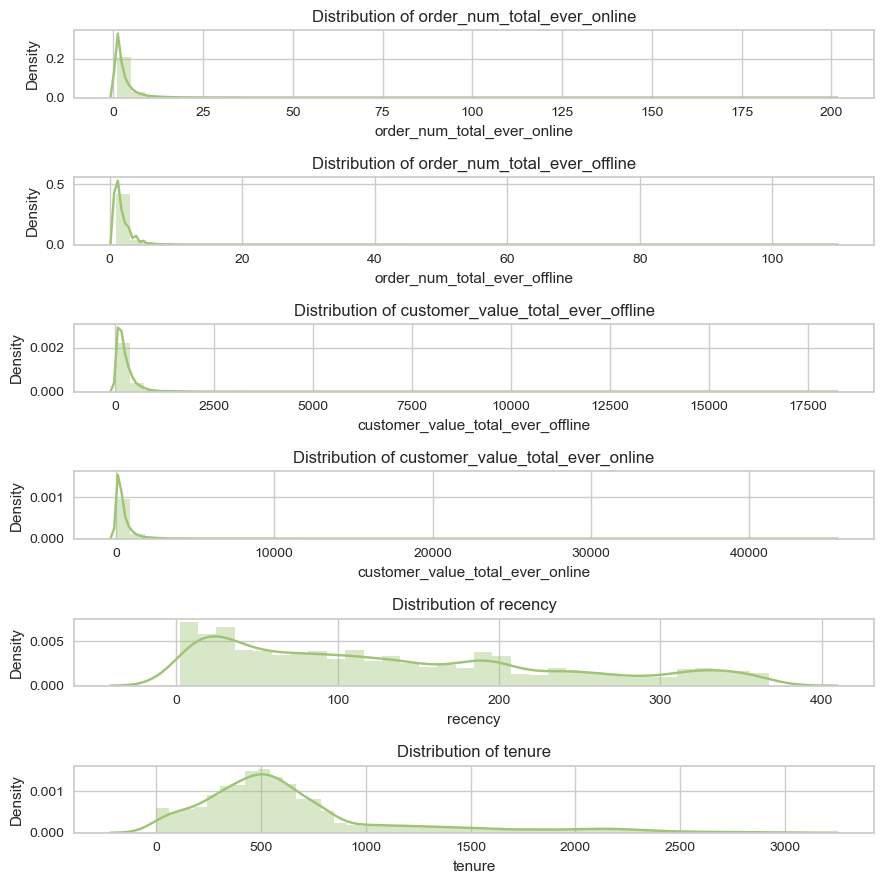

In [10]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column],color = "g")
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

plt.figure(figsize = (9, 9))
plt.subplot(6, 1, 1)
check_skew(model_df,'order_num_total_ever_online')
plt.subplot(6, 1, 2)
check_skew(model_df,'order_num_total_ever_offline')
plt.subplot(6, 1, 3)
check_skew(model_df,'customer_value_total_ever_offline')
plt.subplot(6, 1, 4)
check_skew(model_df,'customer_value_total_ever_online')
plt.subplot(6, 1, 5)
check_skew(model_df,'recency')
plt.subplot(6, 1, 6)
check_skew(model_df,'tenure')
plt.tight_layout()
plt.savefig('before_transform.png', format = 'png', dpi = 1000)

plt.show()

In [11]:
# Normal dağılımın sağlanması için Log transformation uygulanması

model_df['order_num_total_ever_online'] = np.log1p(model_df['order_num_total_ever_online'])
model_df['order_num_total_ever_offline'] = np.log1p(model_df['order_num_total_ever_offline'])
model_df['customer_value_total_ever_offline'] = np.log1p(model_df['customer_value_total_ever_offline'])
model_df['customer_value_total_ever_online'] = np.log1p(model_df['customer_value_total_ever_online'])
model_df['recency'] = np.log1p(model_df['recency'])
model_df['tenure'] = np.log1p(model_df['tenure'])

model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,1.61,0.69,4.95,6.69,4.56,4.79
1,3.00,1.10,5.08,7.53,4.66,7.29
2,1.39,1.10,5.25,5.98,5.23,5.91
3,0.69,0.69,3.71,4.42,4.91,2.48
4,0.69,0.69,3.93,5.08,4.47,6.37


In [12]:
# Scaling

sc = MinMaxScaler((0, 1))

model_scaling = sc.fit_transform(model_df)

model_df = pd.DataFrame(model_scaling,columns = model_df.columns)

model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.20,0.00,0.34,0.50,0.72,0.60
1,0.50,0.10,0.36,0.60,0.74,0.91
2,0.15,0.10,0.39,0.41,0.86,0.74
3,0.00,0.00,0.18,0.22,0.79,0.31
4,0.00,0.00,0.21,0.30,0.70,0.79


**Adım 2:** Optimum küme sayısını belirleyiniz. 

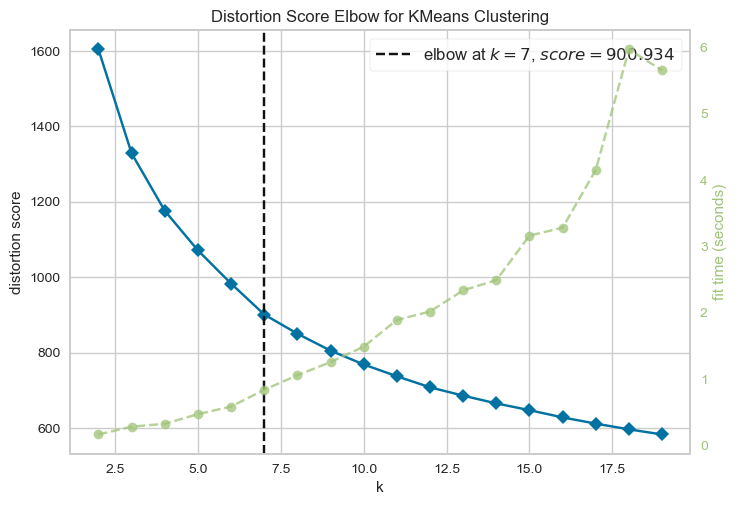

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
kmeans = KMeans()

elbow = KElbowVisualizer(kmeans, k = (2, 20))

elbow.fit(model_df)

elbow.show()

**Adım 3:** Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.

In [14]:
hc = AgglomerativeClustering(n_clusters = 7)
segments = hc.fit_predict(model_df)

final_df = df[["master_id", "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]
final_df["segment"] = segments

final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,5


**Adım 4:** Herbir segmenti istatistiksel olarak inceleyeniz.

In [15]:
final_df.groupby("segment").agg({"order_num_total_ever_online": ["mean", "min", "max"],
                                 "order_num_total_ever_offline": ["mean", "min", "max"],
                                 "customer_value_total_ever_offline": ["mean", "min", "max"],
                                 "customer_value_total_ever_online": ["mean", "min", "max"],
                                 "recency": ["mean", "min", "max"],
                                 "tenure": ["mean", "min", "max", "count"]})

order_num_total_ever_online             order_num_total_ever_offline  \
                               mean  min    max                         mean   
segment                                                                        
0                              1.40 1.00  13.00                         2.19   
1                              4.64 1.00  49.00                         2.41   
2                              6.91 1.00 200.00                         3.08   
3                              1.40 1.00   6.00                         1.20   
4                              4.74 1.00  24.00                         1.12   
5                              1.32 1.00   4.00                         1.61   
6                              2.86 1.00  18.00                         1.22   

                    customer_value_total_ever_offline                 \
         min    max                              mean   min      max   
segment                                                                
0       1.00 109.00                            293.63 10.49 18119.14   
1       1.00  24.00                            336.76 14.99  3425.14   
2       1.00  16.00                            427.12 12.99  2963.24   
3       1.00   6.00                            200.69 12.99  1019.97   
4       1.00   4.00                            123.46 10.00  1049.92   
5       1.00   5.00                            204.32 10.99  1419.98   
6       1.00   4.00                            144.21 12.99   699.97   

        customer_value_total_ever_online                 recency               \
                                    mean    min      max    mean   min    max   
segment                                                                         
0                                 222.68  12.99 30688.47  229.93 33.00 367.00   
1                                 790.85  23.99 12545.37   15.25  2.00  86.00   
2                                1104.12 139.98 45220.13  131.57 14.00 365.00   
3                                 227.42  26.99  1389.60   92.52  4.00 367.00   
4                                 722.77  59.98  7665.28  196.52 36.00 367.00   
5                                 181.46  14.00  1307.33   97.64 18.00 322.00   
6                                 484.78  19.99  4129.27   32.77  5.00 108.00   

        tenure                       
          mean    min     max count  
segment                              
0       501.81   3.00 2820.00  5646  
1       797.89  18.00 3034.00  2510  
2       914.49 109.00 3016.00  2396  
3        80.26   0.00  555.00   985  
4       876.95  71.00 2964.00  2823  
5       693.37 108.00 2911.00  3101  
6       631.38  29.00 2993.00  2484

#### Görev 3: Hierarchical Clustering ile Müşteri Segmentasyonu

**Adım 1:** Görev 2'de standırlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz.

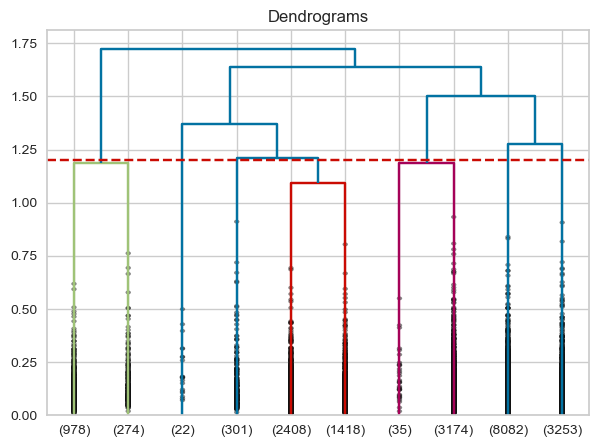

In [16]:
hc_complete = linkage(model_df, 'complete')

plt.figure(figsize = (7, 5))
plt.title("Dendrograms")

dend = dendrogram(hc_complete,
           truncate_mode = "lastp",
           p = 10,
           show_contracted  =True,
           leaf_font_size = 10)

plt.axhline(y = 1.2, color = 'r', linestyle = '--')

plt.show()

**Adım 2:** Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.

In [17]:
hc = AgglomerativeClustering(n_clusters = 5)

segments = hc.fit_predict(model_df)

segments

array([3, 2, 0, ..., 1, 0, 0], dtype=int64)

In [18]:
final_df = df[["master_id", "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online", "recency", "tenure"]]

final_df["segment"] = segments

final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.00,1.00,139.99,799.38,95.00,119.00,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.00,2.00,159.97,1853.58,105.00,1469.00,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.00,2.00,189.97,395.35,186.00,366.00,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.00,1.00,39.99,81.98,135.00,11.00,3
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.00,1.00,49.99,159.99,86.00,582.00,0


In [19]:
final_df["segment"].value_counts()

0    8747
1    4994
4    2823
2    2396
3     985
Name: segment, dtype: int64

**Adım 3:** Her bir segmenti istatistiksel olarak inceleyeniz.

In [20]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean", "min", "max"],
                                 "order_num_total_ever_offline":["mean", "min", "max"],
                                 "customer_value_total_ever_offline":["mean", "min", "max"],
                                 "customer_value_total_ever_online":["mean", "min", "max"],
                                 "recency":["mean", "min", "max"],
                                 "tenure":["mean", "min", "max", "count"]})

order_num_total_ever_online             order_num_total_ever_offline  \
                               mean  min    max                         mean   
segment                                                                        
0                              1.37 1.00  13.00                         1.99   
1                              3.75 1.00  49.00                         1.82   
2                              6.91 1.00 200.00                         3.08   
3                              1.40 1.00   6.00                         1.20   
4                              4.74 1.00  24.00                         1.12   

                    customer_value_total_ever_offline                 \
         min    max                              mean   min      max   
segment                                                                
0       1.00 109.00                            261.97 10.49 18119.14   
1       1.00  24.00                            240.98 12.99  3425.14   
2       1.00  16.00                            427.12 12.99  2963.24   
3       1.00   6.00                            200.69 12.99  1019.97   
4       1.00   4.00                            123.46 10.00  1049.92   

        customer_value_total_ever_online                 recency               \
                                    mean    min      max    mean   min    max   
segment                                                                         
0                                 208.07  12.99 30688.47  183.03 18.00 367.00   
1                                 638.61  19.99 12545.37   23.96  2.00 108.00   
2                                1104.12 139.98 45220.13  131.57 14.00 365.00   
3                                 227.42  26.99  1389.60   92.52  4.00 367.00   
4                                 722.77  59.98  7665.28  196.52 36.00 367.00   

        tenure                       
          mean    min     max count  
segment                              
0       569.72   3.00 2911.00  8747  
1       715.07  18.00 3034.00  4994  
2       914.49 109.00 3016.00  2396  
3        80.26   0.00  555.00   985  
4       876.95  71.00 2964.00  2823